## 『本次練習內容』
#### 運用這幾天所學觀念搭建一個CNN分類器

## 『本次練習目的』
  #### 熟悉CNN分類器搭建步驟與原理
  #### 學員們可以嘗試不同搭法，如使用不同的Maxpooling層，用GlobalAveragePooling取代Flatten等等

In [2]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x是圖片,y是答案label

print(x_train.shape) #(50000, 32, 32, 3)

## Normalize Data
def normalize(X_train,X_test):
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7) 
        return X_train, X_test,mean,std
    
    
## Normalize Training and Testset    
x_train, x_test,mean_train,std_train = normalize(x_train, x_test) 

170500096/170498071 [==============================] - 22s 0us/step
(50000, 32, 32, 3)


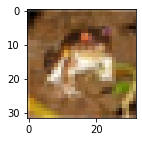

[6]


In [6]:
#Cifar-10 的所有圖片被分為 10 個類別 (以 0~9 數字作為 Label 之編碼) :
#0 : airplain (飛機)
#1 : automobile (汽車)
#2 : bird (鳥)
#3 : cat (貓)
#4 : deer (鹿)
#5 : dog (狗)
#6 : frog (青蛙)
#7 : horse (馬)
#8 : ship (船)
#9 : truck (卡車)
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # x是圖片,y是答案label
import matplotlib.pyplot as plt

def plot_image(image):
    fig=plt.gcf()
    fig.set_size_inches(2, 2)                          
    plt.imshow(image, cmap='binary')
    plt.show()

plot_image(x_train[0])
print(y_train[0]) 

In [7]:
## OneHot Label 由(None, 1)-(None, 10)
## ex. label=2,變成[0,0,1,0,0,0,0,0,0,0]
one_hot=OneHotEncoder()
y_train=one_hot.fit_transform(y_train).toarray()
y_test=one_hot.transform(y_test).toarray()

C:\Users\lag94\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
classifier=Sequential()

#卷積組合
classifier.add(Convolution2D(32,(3,3),input_shape=(32,32,3),activation='relu'))
classifier.add(BatchNormalization())##BatchNormalization
classifier.add(MaxPooling2D(pool_size=(2,2)))

#卷積組合
classifier.add(Convolution2D(32,(3,3),activation='relu'))
classifier.add(BatchNormalization())##BatchNormalization
classifier.add(MaxPooling2D(pool_size=(2,2)))

#flatten
classifier.add(Flatten())

#FC
classifier.add(Dense(units=100,activation='relu',kernel_regularizer=regularizers.l2(l=0.001))) ##regularizers
classifier.add(BatchNormalization()) ##BatchNormalization
classifier.add(Dropout(rate=0.5)) ##Dropout

classifier.add(Dense(units=100,activation='relu',kernel_regularizer=regularizers.l2(0.001)))##regularizers
classifier.add(BatchNormalization()) ##BatchNormalization

classifier.add(Dropout(rate=0.3))##Dropout

classifier.add(Dense(units=10,activation='softmax'))
#超過兩個就要選categorical_crossentrophy
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
from keras.preprocessing.image import ImageDataGenerator ##Augmentation
img_gen = ImageDataGenerator( featurewise_center=True,featurewise_std_normalization=True,rotation_range=10,width_shift_range=0.1,
                                            height_shift_range=0.1,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=False,dtype=np.float32)
img_gen.fit(x_train)
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='test_loss', patience=8, verbose=1) ##earlystop


In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals
import sys
import tensorflow as tf
print(sys.version)#3.7.3
print(tf.__version__)
print(tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Num GPUs Available:  1


RuntimeError: Device placement logging must be set at program startup

In [14]:
##開始訓練
classifier.fit_generator(img_gen.flow(x_train, y_train, batch_size=100) ,steps_per_epoch=500,
                               epochs=100, validation_data = (x_test, y_test),callbacks = [earlystop])
#classifier.fit_generator(img_gen.flow(x_train, y_train, batch_size=10) ,steps_per_epoch=100,
                               #epochs=10, validation_data = (x_test, y_test))

Epoch 1/100
500/500 [==============================] - 17s 34ms/step - loss: 1.3532 - accuracy: 0.5779 - val_loss: 98.5003 - val_accuracy: 0.2498
Epoch 2/100
500/500 [==============================] - 16s 31ms/step - loss: 1.2971 - accuracy: 0.5903 - val_loss: 115.9629 - val_accuracy: 0.2073
Epoch 3/100
500/500 [==============================] - 17s 33ms/step - loss: 1.2629 - accuracy: 0.6005 - val_loss: 69.5296 - val_accuracy: 0.2620
Epoch 4/100
500/500 [==============================] - 15s 31ms/step - loss: 1.2232 - accuracy: 0.6111 - val_loss: 68.3189 - val_accuracy: 0.2721
Epoch 5/100
500/500 [==============================] - 17s 33ms/step - loss: 1.1979 - accuracy: 0.6219 - val_loss: 61.7774 - val_accuracy: 0.2108
Epoch 6/100
500/500 [==============================] - 15s 31ms/step - loss: 1.1863 - accuracy: 0.6247 - val_loss: 57.9871 - val_accuracy: 0.2813
Epoch 7/100
500/500 [==============================] - 17s 33ms/step - loss: 1.1687 - accuracy: 0.6350 - val_loss: 74.6162 

500/500 [==============================] - 16s 31ms/step - loss: 0.9961 - accuracy: 0.7009 - val_loss: 65.1889 - val_accuracy: 0.2095
Epoch 57/100
500/500 [==============================] - 16s 33ms/step - loss: 1.0005 - accuracy: 0.6979 - val_loss: 91.1389 - val_accuracy: 0.1957
Epoch 58/100
500/500 [==============================] - 16s 31ms/step - loss: 0.9984 - accuracy: 0.7009 - val_loss: 60.0984 - val_accuracy: 0.2439
Epoch 59/100
500/500 [==============================] - 16s 33ms/step - loss: 0.9901 - accuracy: 0.7026 - val_loss: 64.5103 - val_accuracy: 0.2272
Epoch 60/100
500/500 [==============================] - 16s 33ms/step - loss: 0.9939 - accuracy: 0.6998 - val_loss: 121.7136 - val_accuracy: 0.1801
Epoch 61/100
500/500 [==============================] - 18s 35ms/step - loss: 0.9974 - accuracy: 0.6984 - val_loss: 52.8952 - val_accuracy: 0.2603
Epoch 62/100
500/500 [==============================] - 16s 32ms/step - loss: 0.9879 - accuracy: 0.7015 - val_loss: 79.5881 - val_

## 預測新圖片，輸入影像前處理要與訓練時相同
#### ((X-mean)/(std+1e-7) ):這裡的mean跟std是訓練集的
## 維度如下方示範

In [15]:
input_example=(np.zeros(shape=(1,32,32,3))-mean_train)/(std_train+1e-7) 
classifier.predict(input_example)

array([[0.0056375 , 0.00144799, 0.05863515, 0.06677468, 0.28529808,
        0.00884047, 0.561312  , 0.00396071, 0.00678896, 0.00130454]],
      dtype=float32)